In [1977]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from pathlib import Path
from utils import rotate_dataset

## Number of neighbors

Check how the result of the manifold sculpting depends on the number of neighbors used. Compare with other popular algorithms.

In [1978]:
data_folder = Path('../data/results/neighbors/')
figures_folder = Path('../figs/SwissRoll/')
dataset2d_path = Path('../data/datasets/2d/N_2000.npy')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")


if not dataset2d_path.exists():
    raise FileNotFoundError(f"Dataset 2D file {dataset2d_path} does not exist. Please provide a valid dataset path.")

n_neighbors = [20, 28, 40, 57, 80]

isomap_paths = {n_neighbors[i]: file for i, file in enumerate(sorted(data_folder.glob('Isomap_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1])))}
lle_paths = {n_neighbors[i]: file for i, file in enumerate(sorted(data_folder.glob('LLE_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1])))}
ms_paths = {n_neighbors[i]: file for i, file in enumerate(sorted(data_folder.glob('MS_[0-9][0-9].npy'), key=lambda x: int(x.stem.split('_')[1])))}

times_files = list(data_folder.glob('*_time.npy'))
time_key = lambda x: str(x.stem.split('_')[0])
times_files = {time_key(file): file for file in times_files if time_key(file) in file.name}

In [1979]:
isomap_files = {}
lle_files = {}
ms_files = {}

for n in n_neighbors:
    isomap_files[n] = np.loadtxt(isomap_paths[n])
    lle_files[n] = np.loadtxt(lle_paths[n])
    ms_files[n] = np.loadtxt(ms_paths[n])
    
X_2d = np.load(dataset2d_path)

### Time comparison

Check how much time is required to complete the calculation.

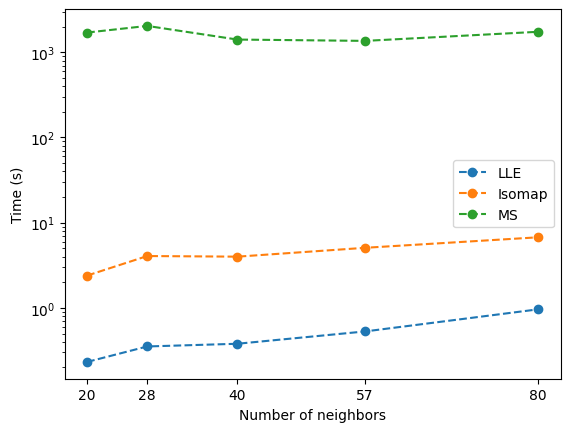

In [1980]:
for key in list(times_files.keys()):
    data = np.loadtxt(times_files[key])
    plt.semilogy(n_neighbors, data, label=key, marker='o', linestyle='--')

plt.xlabel('Number of neighbors')
plt.ylabel('Time (s)')
plt.xticks(n_neighbors)
plt.legend()
plt.show()

In [1981]:
ms_keys = sorted(ms_files.keys())
rotated_dataset = {}
for key in ms_keys:
    # Rotate the data
    rotated_dataset[key] = rotate_dataset(ms_files[key])

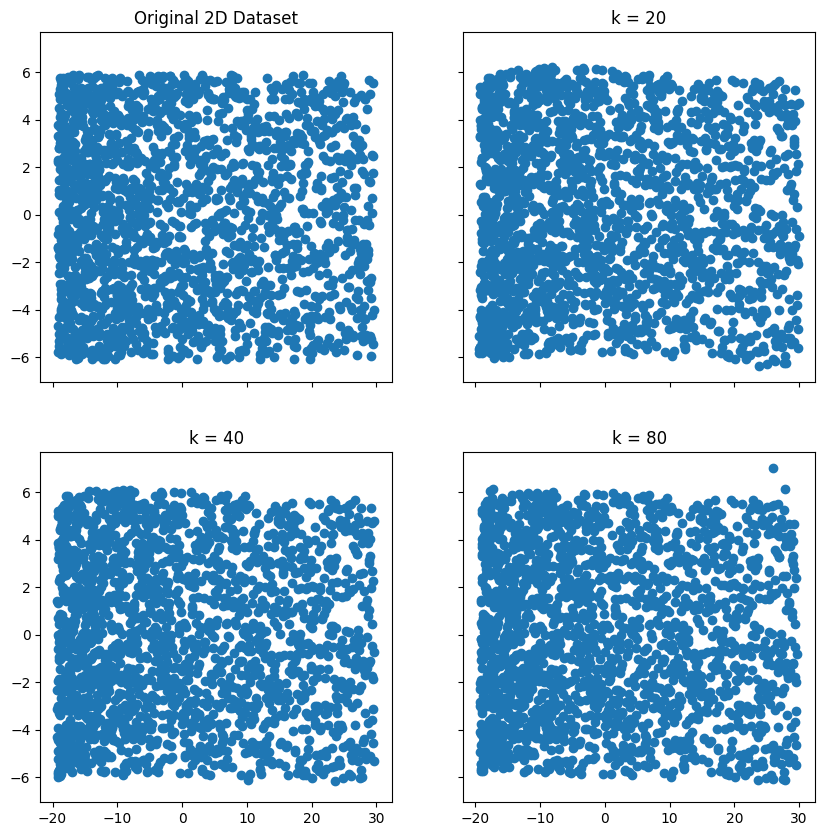

In [1982]:
# Plotting the rotated datasets for each number of neighbors
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

X_2d -= X_2d.mean(axis=0)
# X_2d[:, 1] *= -1  # Invert the y-axis for better visualization

axs[0, 0].scatter(X_2d[:, 0], X_2d[:, 1], label="Original 2D Dataset")
axs[0, 0].set_title("Original 2D Dataset")

k, j = 0, 1
for i, key in enumerate(ms_keys):
    if i == 1 or i == 3:
        continue
    X_ms = rotated_dataset[key]
    
    axs[k, j].scatter(X_ms[:, 0], X_ms[:, 1], label=f"MS {key}")
    axs[k, j].set_title(f"k = {key}")
    
    j += 1
    if j == 2:
        j = 0
        k += 1
        
plt.show()

In [1983]:
mse_isomap = np.zeros(len(isomap_files))
mse_lle = np.zeros(len(lle_files))
mse_ms = np.zeros(len(ms_files))

X_2D_scal = minmax_scale(X_2d)

X_isomap_scal = {}
X_lle_scal = {}
X_ms_scal = {}

for i, key in enumerate(n_neighbors):
    X_isomap_scal[key] = minmax_scale(isomap_files[key].copy())
    X_lle_scal[key] = minmax_scale(lle_files[key].copy())
    X_ms_scal[key] = minmax_scale(rotated_dataset[key].copy())
    

    if i == 0 or i == 2 or i == 4:
        X_ms_scal[key][:, 1] *= -1
        X_ms_scal[key][:, 1] += 1
    
    if i == 1:
        X_ms_scal[key][:, 0] *= -1
        X_ms_scal[key][:, 0] += 1
        X_ms_scal[key][:, 1] *= -1
        X_ms_scal[key][:, 1] += 1
    
    # if i == 3:
    #     X_lle_scal[key][:, 0] *= -1
    #     X_lle_scal[key][:, 0] += 1
        
    
    mse_isomap[i] = mean_squared_error(X_2D_scal, X_isomap_scal[key])
    mse_lle[i] = mean_squared_error(X_2D_scal, X_lle_scal[key])
    mse_ms[i] = mean_squared_error(X_2D_scal, X_ms_scal[key][:, 0:2])



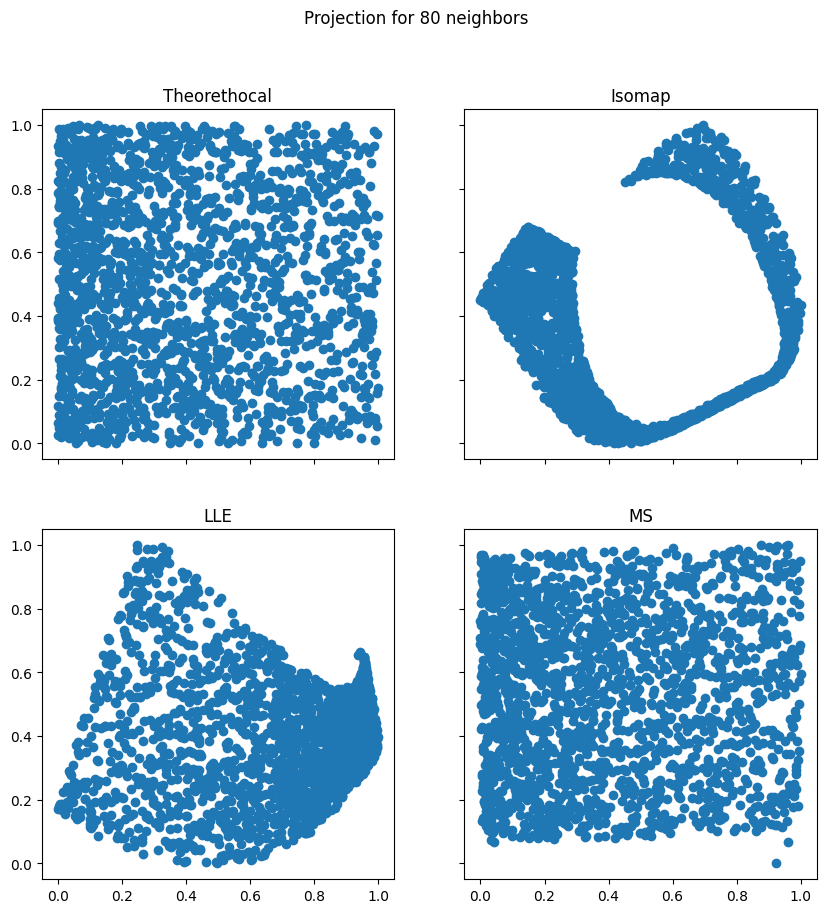

In [1984]:
i = 4
key = n_neighbors[i]

Xi = X_isomap_scal[key].copy()
Xl = X_lle_scal[key].copy()
Xm = X_ms_scal[key].copy()


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].scatter(X_2D_scal[:, 0], X_2D_scal[:, 1])
ax[0, 0].set_title('Theorethocal')

ax[0, 1].scatter(Xi[:, 0], Xi[:, 1])
ax[0, 1].set_title('Isomap')

ax[1, 0].scatter(Xl[:, 0], Xl[:, 1])
ax[1, 0].set_title('LLE')

ax[1, 1].scatter(Xm[:, 0], Xm[:, 1])
ax[1, 1].set_title('MS')

fig.suptitle(f'Projection for {key} neighbors')

plt.show()

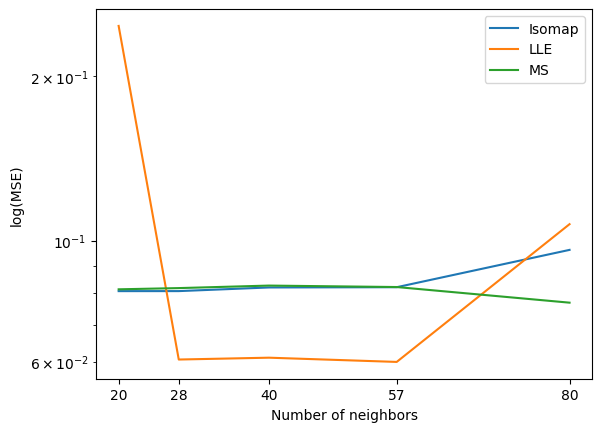

In [1985]:

plt.semilogy(n_neighbors, mse_isomap, label='Isomap')
plt.semilogy(n_neighbors, mse_lle, label='LLE')
plt.semilogy(n_neighbors, mse_ms, label='MS')
plt.xticks(n_neighbors)
plt.xlabel('Number of neighbors')
plt.ylabel('log(MSE)')
plt.legend()
plt.show()

## Sizes

In [1986]:
data_folder = Path('../data/results/sizes/')
dataset2d_folder = Path('../data/datasets/2d/')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")
if not dataset2d_folder.exists():
    raise FileNotFoundError(f"Dataset 2D folder {dataset2d_folder} does not exist. Please provide a valid dataset path.")

isomap_paths = sorted(data_folder.glob('isomap_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
lle_paths = sorted(data_folder.glob('LLE_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
ms_paths = sorted(data_folder.glob('MS_[0-9][0-9]*.npy'), key=lambda x: int(x.stem.split('_')[1]))



X_2D_files = sorted(dataset2d_folder.glob('N_*.npy'), key=lambda x: int(x.stem.split('_')[1]))
if not X_2D_files:
    raise FileNotFoundError(f"No 2D dataset files found in {dataset2d_folder}. Please provide a valid dataset path.")

In [1987]:
sizes = [250, 500, 1000]

rotated_dataset = {}

X_isomap_scal = {}
X_lle_scal = {}
X_ms_scal = {}
X_2D_scal = {}

mse_isomap = []
mse_lle = []
mse_ms = []

for i, s in enumerate(sizes):
    isomap_file = np.loadtxt(data_folder / f'isomap_{s}.npy')
    lle_file = np.loadtxt(data_folder / f'LLE_{s}.npy')
    ms_file = np.loadtxt(data_folder / f'MS_{s}.npy')
    X_2D = np.load(dataset2d_folder / f"N_{s}.npy")
    
    rotated_dataset[s] = rotate_dataset(ms_file)
    
    X_2D_scal[s] = minmax_scale(X_2D)
    X_isomap_scal[s] = minmax_scale(isomap_file)
    X_lle_scal[s] = minmax_scale(lle_file)
    X_ms_scal[s] = minmax_scale(rotated_dataset[s])
    
    if i == 0 or i == 2:
        X_ms_scal[s][:, 0] *= -1
        X_ms_scal[s][:, 0] += 1
    
    mse_isomap.append(mean_squared_error(X_2D_scal[s], X_isomap_scal[s]))
    mse_lle.append(mean_squared_error(X_2D_scal[s], X_lle_scal[s]))
    mse_ms.append(mean_squared_error(X_2D_scal[s], X_ms_scal[s][:, 0:2]))

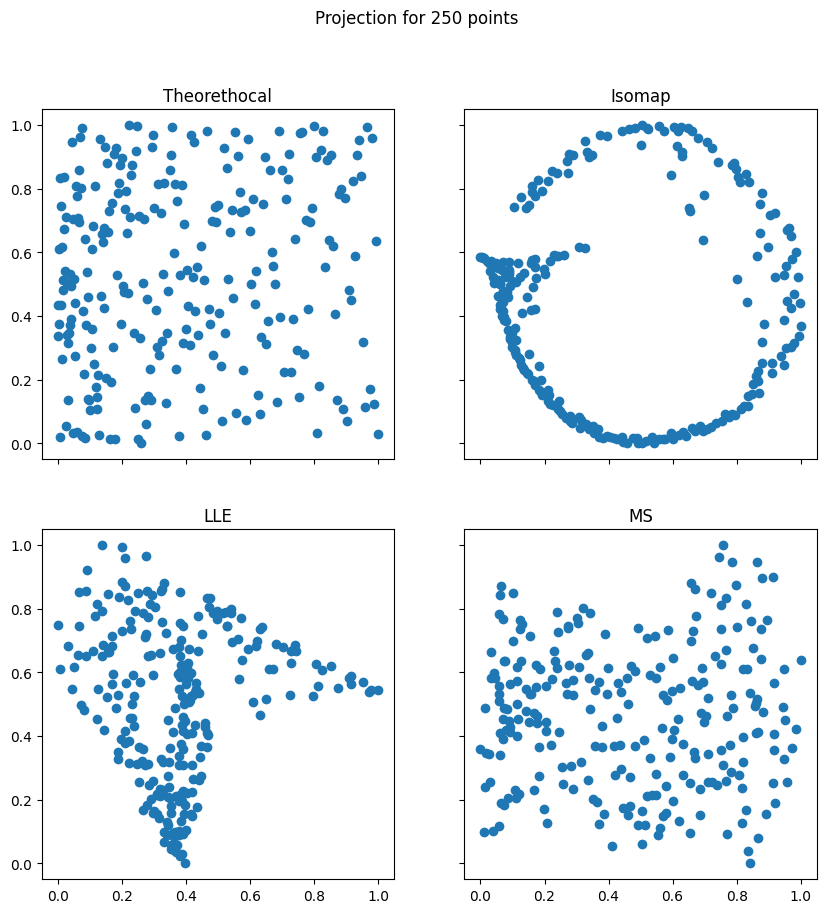

In [1988]:
i = 0
size = sizes[i]

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].scatter(X_2D_scal[size][:, 0], X_2D_scal[size][:, 1])
ax[0, 0].set_title('Theorethocal')

ax[0, 1].scatter(X_isomap_scal[size][:, 0], X_isomap_scal[size][:, 1])
ax[0, 1].set_title('Isomap')

ax[1, 0].scatter(X_lle_scal[size][:, 0], X_lle_scal[size][:, 1])
ax[1, 0].set_title('LLE')

ax[1, 1].scatter(X_ms_scal[size][:, 0], X_ms_scal[size][:, 1])
ax[1, 1].set_title('MS')

plt.suptitle(f'Projection for {size} points')
plt.show()


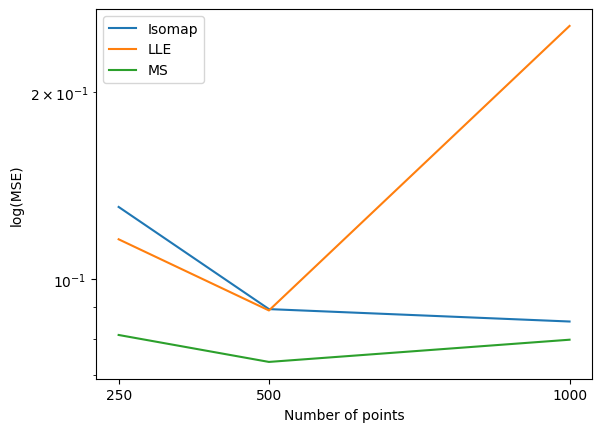

In [1989]:
plt.semilogy(sizes, mse_isomap, label='Isomap')
plt.semilogy(sizes, mse_lle, label='LLE')
plt.semilogy(sizes, mse_ms, label='MS')
plt.xticks(sizes)
plt.xlabel('Number of points')
plt.ylabel('log(MSE)')
plt.legend()
plt.show()

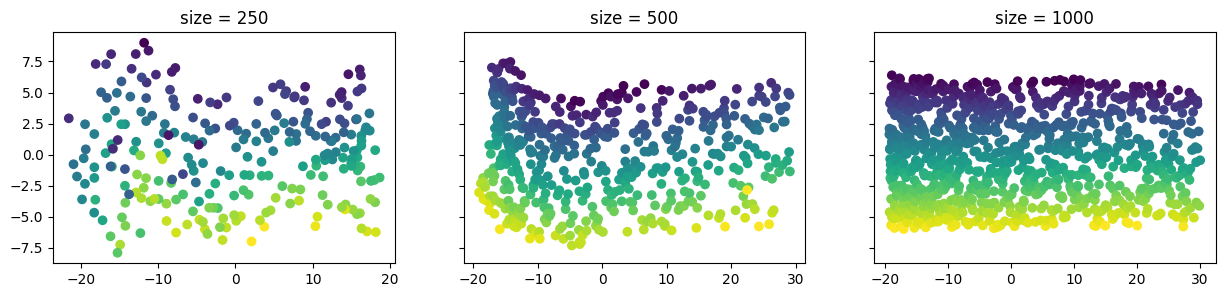

In [1990]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

for i, size in enumerate(sizes):
    X_ms = rotated_dataset[size]
    if i== 2:
        X_ms[:, 0] *= -1
        X_ms[:, 1] *= -1
    axs[i].scatter(X_ms[:, 0], X_ms[:, 1], c=X_ms[:, 2], label=f"size = {size}", cmap='viridis')
    axs[i].set_title(f"size = {size}")
plt.show()

# Sigma

In [1991]:
data_folder = Path('../data/results/scale_factors/')

if not data_folder.exists():
    raise FileNotFoundError(f"Data folder {data_folder} does not exist. Please provide a valid dataset path.")

dataset2d_path = Path('../data/datasets/2d/N_1000.npy')

if not dataset2d_path.exists():
    raise FileNotFoundError(f"Dataset 2D file {dataset2d_path} does not exist. Please provide a valid dataset path.")

sigmas = [0.80, 0.85, 0.99]

ms_paths = sorted(data_folder.glob('MS_[0-9]*.npy'))

In [1992]:
ms_files = {}
for i, sigma in enumerate(sigmas):
    ms_files[sigma] = np.loadtxt(data_folder / f'MS_{i}.npy')

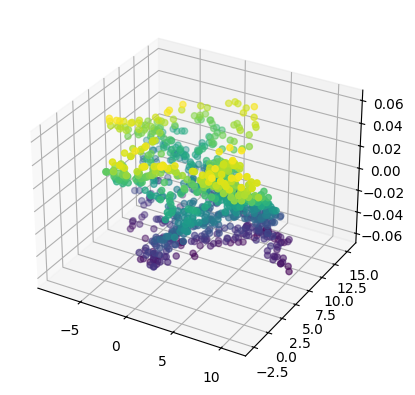

In [1993]:
data = ms_files[sigmas[2]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2])
plt.show()

In [1994]:
X_ms = {}

for sigma in sigmas:
    # Rotate the data
    rotated_dataset = rotate_dataset(ms_files[sigma])
    X_ms[sigma] = minmax_scale(rotated_dataset)

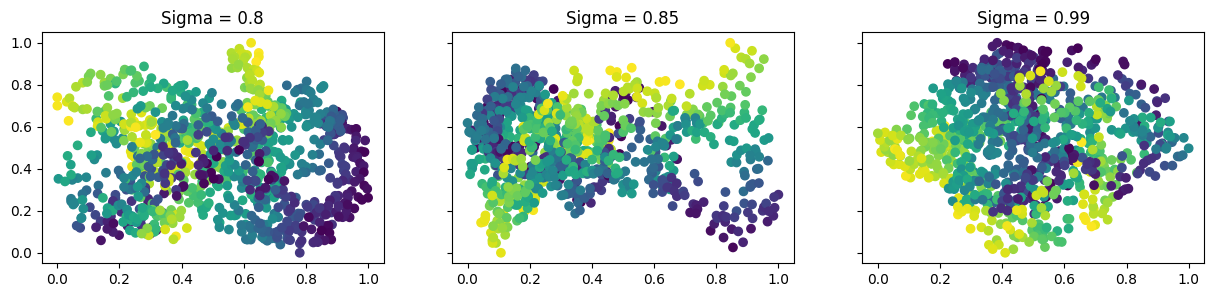

In [1995]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

for i, sigma in enumerate(sigmas):
    axs[i].scatter(X_ms[sigma][:, 0], X_ms[sigma][:, 1], c=X_ms[sigma][:, 2], label=str(sigma), cmap='viridis')
    axs[i].set_title(f"Sigma = {sigma}")